# Preprocessed Citibike Data: Exploratory Data Analysis

## Import libraries

In [73]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib.axes as axes

## Import and load data

Import preprocessed data:

In [75]:
cb_raw = pd.read_csv('citibike_final.csv', parse_dates=['starttime', 'stoptime'])

Make a copy: 

In [76]:
cb = cb_raw.copy()

## Inspect data frame

Get dimensions of data frame and datatypes of each feature:

In [77]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015035 entries, 0 to 4015034
Data columns (total 15 columns):
bikeid                   int64
birthyear                int64
endstationid             int64
endstationlatitude       float64
endstationlongitude      float64
endstationname           object
gender                   int64
startstationid           int64
startstationlatitude     float64
startstationlongitude    float64
startstationname         object
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int64
usertype                 object
dtypes: datetime64[ns](2), float64(4), int64(6), object(3)
memory usage: 459.5+ MB


Randomly sample five observations:

In [5]:
cb.head()

,bikeid,birthyear,endstationid,endstationlatitude,endstationlongitude,endstationname,gender,startstationid,startstationlatitude,startstationlongitude,startstationname,starttime,stoptime,tripduration,usertype
0,16852,1991.0,252.0,40.732264,-73.998522,MacDougal St & Washington Sq,1,312.0,40.722055,-73.989111,Allen St & Stanton St,2017-09-01 00:04:15,2017-09-01 00:11:18,422.0,Subscriber
1,27730,1983.0,468.0,40.765265,-73.981923,Broadway & W 56 St,1,478.0,40.760301,-73.998842,11 Ave & W 41 St,2017-09-01 00:06:19,2017-09-01 00:17:09,650.0,Subscriber
2,28032,1989.0,395.0,40.688070,-73.984106,Bond St & Schermerhorn St,1,237.0,40.730473,-73.986724,E 11 St & 2 Ave,2017-09-01 00:07:34,2017-09-01 00:29:49,1334.0,Subscriber
3,15651,1989.0,3449.0,40.721463,-73.948009,Eckford St & Engert Ave,2,3090.0,40.717746,-73.956001,N 8 St & Driggs Ave,2017-09-01 00:10:49,2017-09-01 00:13:52,182.0,Subscriber
4,17018,1900.0,402.0,40.740343,-73.989551,Broadway & E 22 St,0,325.0,40.736245,-73.984738,E 19 St & 3 Ave,2017-09-01 00:11:00,2017-09-01 00:15:39,278.0,Customer


## Data preprocessing

Show unique values per feature:

In [ ]:
pd.DataFrame.from_records([(col, cb[col].nunique()) for col in cb.columns],
                          columns=['Feature', 'Number of Unique Values']).sort_values(by=['Number of Unique Values'])

### Define features

Define numerical features:

In [18]:
cb.birthyear = cb.birthyear.astype('float16').astype('int16')

Define categorical features:

In [19]:
datetime_feat = ['birthyear','starttime', 'stoptime']
cont_feat = map_feat + datetime_feat + ['tripduration']

In [20]:
num_nom_feat = ['bikeid','endstationid','startstationid','gender']
cat_nom_feat = ['endstationname','startstationname','usertype']
nom_feat = num_nom_feat + cat_nom_feat

### Perform datatype conversions

Convert unique ID numbers and trip durations to `int64`:

In [78]:
float_to_int = ['startstationid','endstationid','tripduration', 'bikeid', 'gender']

#change to int16 to reduce memory
cb[float_to_int] = cb[float_to_int].apply(lambda x: x.astype('int16'))

Convert untreated nominal features to categorical datatype:

In [79]:
#and for nominal features
cb[cat_nom_feat] = cb[cat_nom_feat].apply(lambda x: x.astype('category'))

Check for successful datatype conversion and reduction in memory:

In [80]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015035 entries, 0 to 4015034
Data columns (total 15 columns):
bikeid                   int16
birthyear                int64
endstationid             int16
endstationlatitude       float64
endstationlongitude      float64
endstationname           category
gender                   int16
startstationid           int16
startstationlatitude     float64
startstationlongitude    float64
startstationname         category
starttime                datetime64[ns]
stoptime                 datetime64[ns]
tripduration             int16
usertype                 category
dtypes: category(3), datetime64[ns](2), float64(4), int16(5), int64(1)
memory usage: 272.0 MB


## Feature engineering

In [81]:
def extract_part_of_day(hour):
    if hour < 4 and hour>=0:
        return 'early morning'
    if hour < 8 and hour>=4:
        return 'morning'
    if hour < 12 and hour>=8:
        return 'late morning'
    if hour < 16 and hour>=12:
        return 'afternoon'
    if hour < 20 and hour>=16:
        return 'late afternoon/early evening'
    return 'evening'

In [82]:
def extract_decade(age):
    if age <10 and age>=0:
        return 'pre-tens'
    if age <20 and age>=10:
        return 'tens'
    if age <30 and age>=20:
        return 'twenties'
    if age <40 and age>=30:
        return 'thirties'
    if age <50 and age>=40:
        return 'forties'
    if age <60 and age>=50:
        return 'fifties'
    if age <70 and age>=60:
        return 'sixties'
    if age <80 and age>=70:
        return 'seventies'
    if age <90 and age>=80:
        return 'eighties'
    if age <100 and age>=90:
        return 'nineties'
    return 'deceased centenials'

In [83]:
cb['year'] = cb['starttime'].dt.year
cb['day'] = cb['starttime'].dt.dayofweek
cb['hour'] = cb['starttime'].dt.hour
cb['age'] = cb['year'] - cb['birthyear']
cb['dayofyear'] = cb['starttime'].dt.dayofyear

In [84]:
cb['part_of_day'] = cb['starttime'].apply(lambda t: extract_part_of_day(t.hour))

In [85]:
cb['decade'] = cb['age'].apply(lambda t: extract_decade(t))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1549bf490>,
      dtype=object)

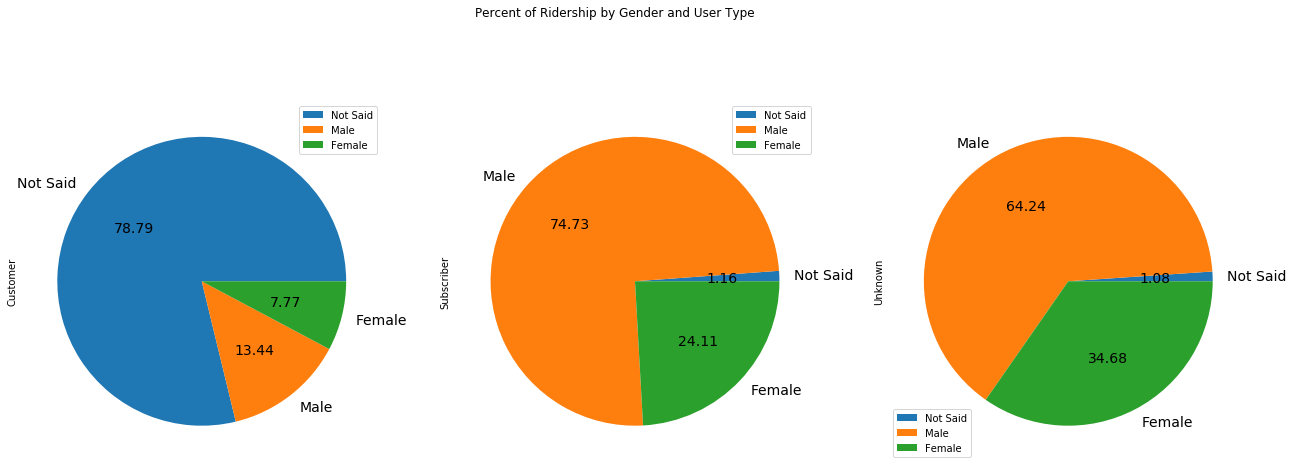

In [89]:
#pie charts showing percent ridership by gender and usertype
cb.groupby(['gender','usertype'])['bikeid'].count().unstack().plot(kind='pie', subplots=True, labels=['Not Said', 'Male', 'Female'], figsize=(22, 8),  fontsize=14, autopct='%.2f', title='Percent of Ridership by Gender and User Type')

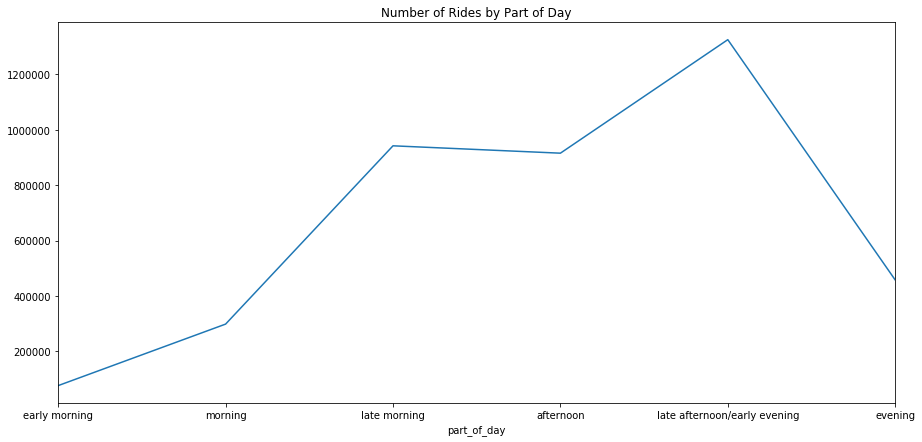

In [66]:
#number of rides by part of day
#tinker to get this into a histogram or scatter plot

fig, ax = plt.subplots(figsize=(15,7))
cb.groupby('part_of_day')['bikeid'].count().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening']).plot(ax=ax, title='Number of Rides by Part of Day')

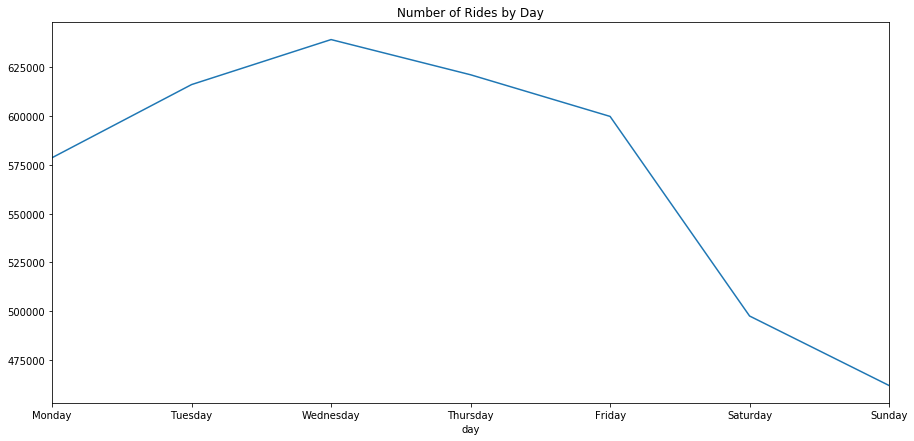

In [67]:
#number of rides by day
#histogram or scatterplot

fig, ax = plt.subplots(figsize=(15,7))
cb.groupby('day')['bikeid'].count().rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}).plot(ax=ax, title='Number of Rides by Day')

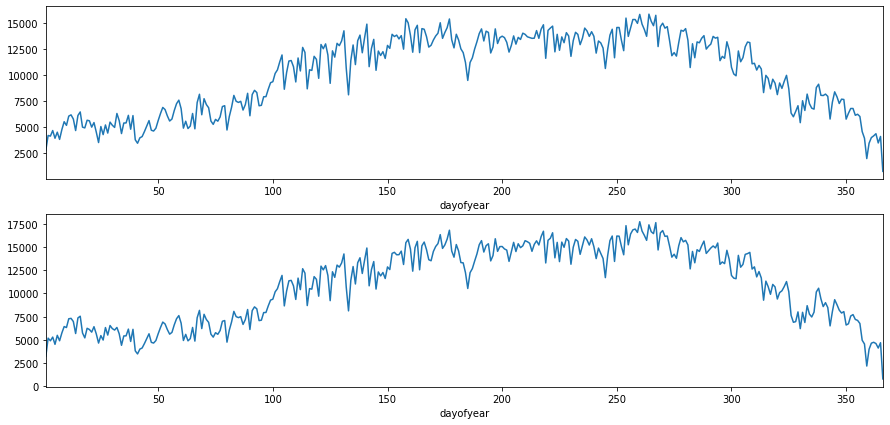

In [103]:
#Number of rides by day of the year

fig, (ax1, ax2) = plt.subplots(figsize=(15,7), nrows=2)
temp = cb[cb.year!=2020]
temp = temp[temp.year!=2013]
temp.groupby(['dayofyear'])['bikeid'].count().plot(ax=ax1)
cb.groupby(['dayofyear'])['bikeid'].count().plot(ax=ax2)

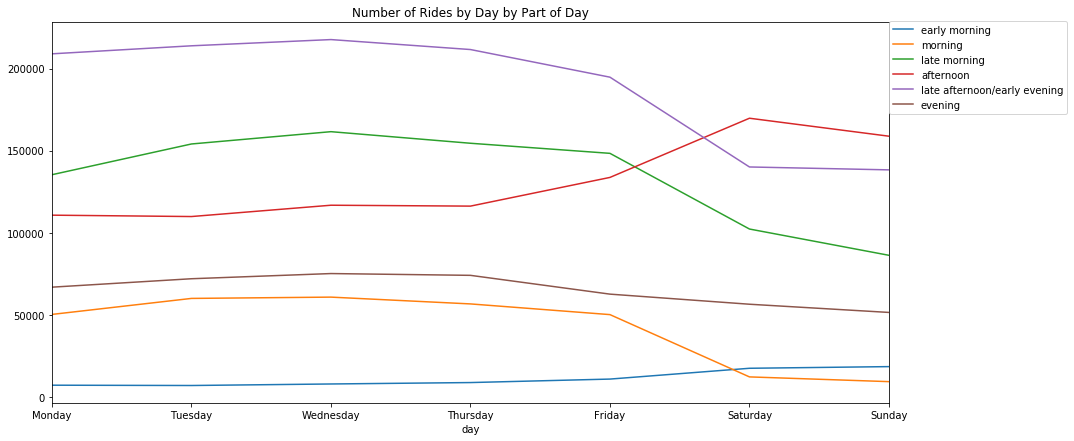

In [61]:
#number of rides by part of day by day

dat = cb.groupby(['day','part_of_day']).count()['bikeid'].unstack().rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}).stack().swaplevel(i='day', j='part_of_day').unstack().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening']).stack().swaplevel(i='part_of_day', j='day').unstack()
fig, ax = plt.subplots(figsize=(15,7))
dat.plot(ax=ax)
plt.title('Number of Rides by Day by Part of Day')
plt.legend(loc=[1,0.76])

part_of_day
early morning                    44688
morning                         163914
late morning                    406475
afternoon                       364616
late afternoon/early evening    617536
evening                         223552
dtype: int64


Text(0.5, 1.0, 'Number of Rides by Part of Day by Gender')

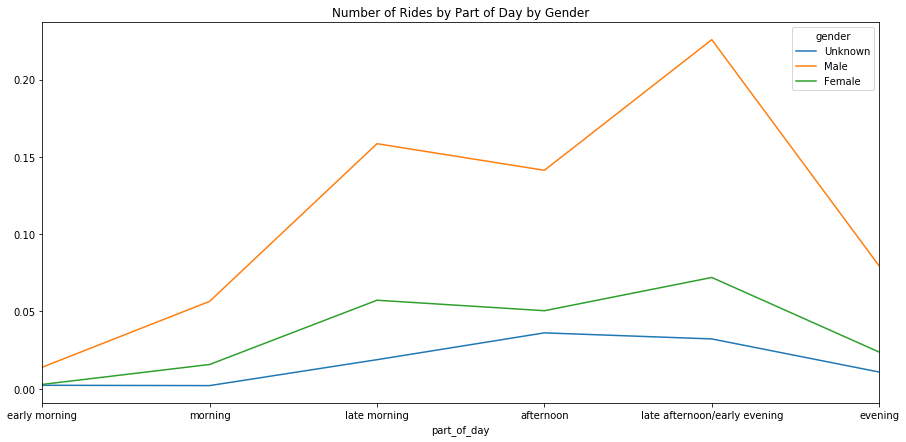

In [104]:
#number of rides by part of day and gender
male  = cb.groupby(['gender', 'part_of_day']).count()['bikeid'].unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack().swaplevel(i='gender', j='part_of_day').unstack().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])['Male']
female = cb.groupby(['gender', 'part_of_day']).count()['bikeid'].unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack().swaplevel(i='gender', j='part_of_day').unstack().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])['Female']
print(male-female)

fig, ax = plt.subplots(figsize=(15,7))
(cb.groupby(['gender', 'part_of_day']).count()['bikeid'].unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack().swaplevel(i='gender', j='part_of_day').unstack().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])/len(cb.bikeid)).plot(ax=ax)
plt.title('Number of Rides by Part of Day by Gender')

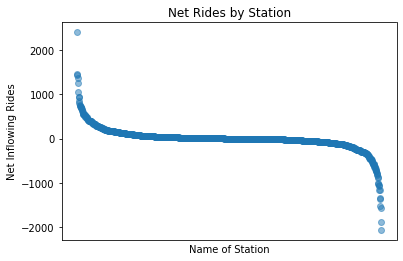

In [430]:
#Number of rides by name of starting station
#tinker with this more
start = cb.groupby(['startstationname'])['bikeid'].count()
stop = cb.groupby(['endstationname'])['bikeid'].count()
y = (stop-start).sort_values(ascending=False).values
x = (stop-start).sort_values(ascending=False).index

plt.scatter(x, y, alpha=0.5)
plt.xlabel('Unique Stations')
plt.ylabel('Net Inflowing Rides')
plt.title('Net Rides by Station')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()
# fig, ax = plt.subplots(figsize=(15,7))
# cb.groupby(['startstationname'])['bikeid'].count().sort_values(ascending=False).plot(ax=ax)
# plt.title('Number of Rides by Unique Station')

In [106]:
start = cb.groupby(['part_of_day','startstationname'])['bikeid'].count().unstack().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])
stop = cb.groupby(['part_of_day','endstationname'])['bikeid'].count().unstack().reindex(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])
grouped = (stop-start).stack().groupby('part_of_day')

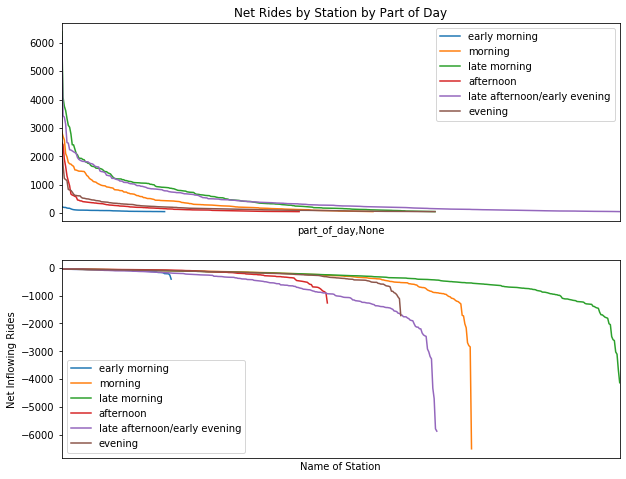

In [107]:
#tweak this visualization later
fig, (ax1, ax2) = plt.subplots(figsize=(10,8), nrows=2)

for name, group in grouped:
    line1 = group.sort_values(ascending=False)[group>50].plot(ax=ax1, title='Net Rides by Station by Part of Day')
    line2 = group.sort_values(ascending=False)[group<-50].plot(ax=ax2)

#axes.SubplotBase(fig, label_outer='Net Inflowing Rides')
plt.xlabel('Name of Station')
plt.ylabel('Net Inflowing Rides')
ax1.legend(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax2.legend(['early morning', 'morning', 'late morning', 'afternoon', 'late afternoon/early evening', 'evening'])
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

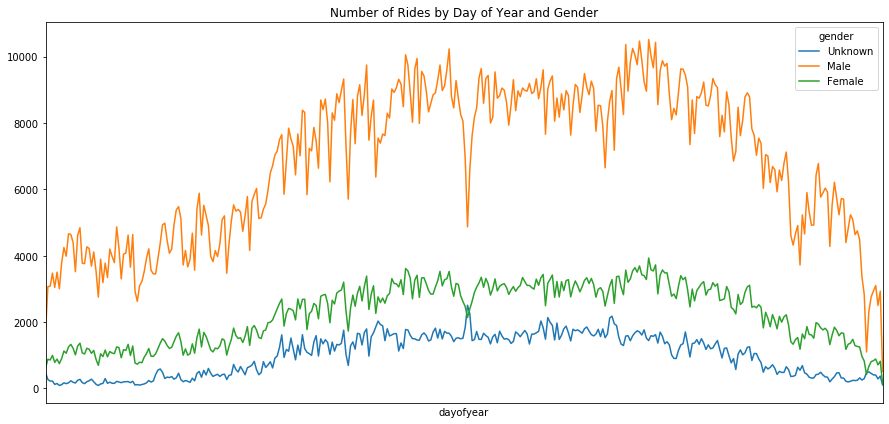

In [110]:
#Number of Rides by Day of Year and Gender
fig, ax = plt.subplots(figsize=(15,7))
temp.groupby(['gender', 'dayofyear'])['bikeid'].count().unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack().swaplevel(i='gender',j='dayofyear').unstack().plot(ax=ax)
plt.title('Number of Rides by Day of Year and Gender')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

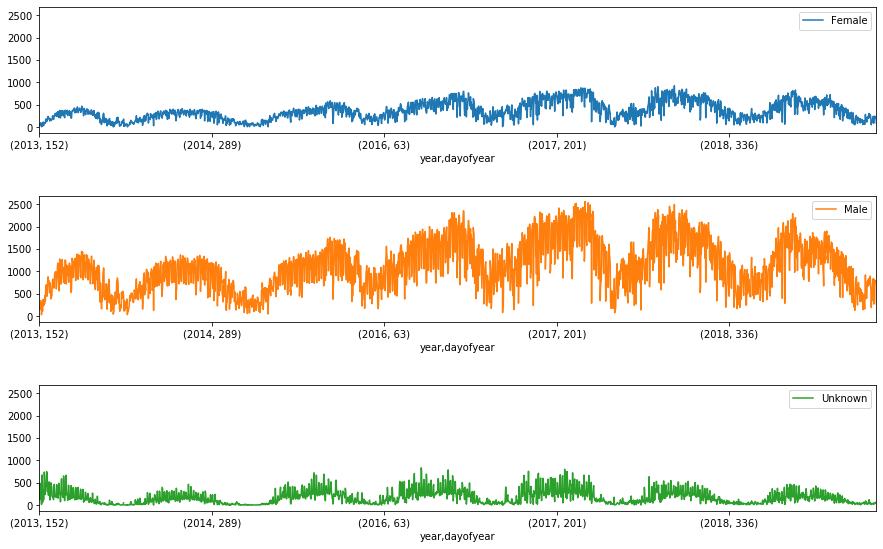

In [470]:
#tweak to make this duple of (month, day)
#Number of rides by day of the year and gender
#cb.groupby(['gender','dayofyear', 'year'])['bikeid'].count().unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack().swaplevel(i='gender', j='year').unstack()

fig, ax = plt.subplots(figsize=(15,7))
# cb.groupby(['dayofyear', 'gender'])['bikeid'].count().unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack()..plot(ax=ax, subplots=True)
cb.groupby(['gender','dayofyear', 'year'])['bikeid'].count().unstack().rename(index={0:"Unknown", 1:"Male", 2:"Female"}).stack().swaplevel(i='gender', j='year').unstack().plot(ax=ax, subplots=True, sharey=True)
plt.subplots_adjust(bottom=0, right=0.9, top=1, hspace = 0.5)

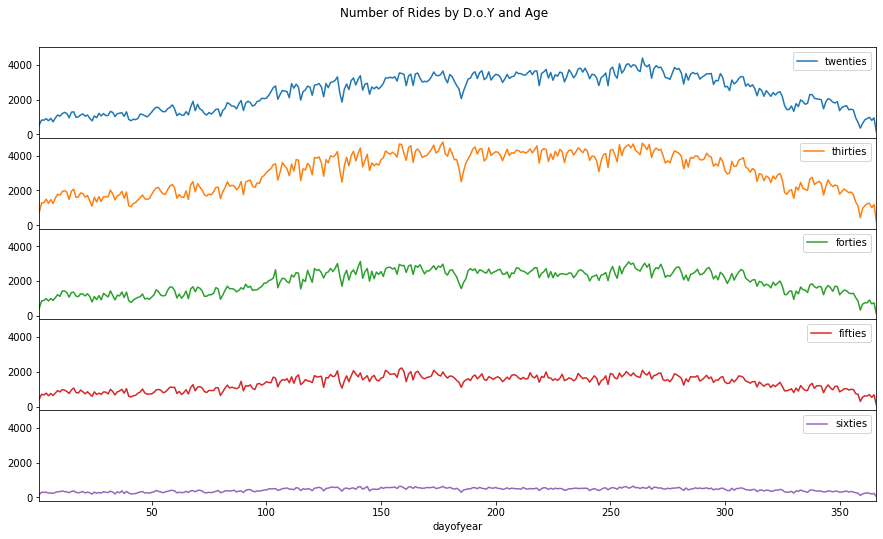

In [131]:
#Number of rides by day of the year and age

fig, ax = plt.subplots(figsize=(15,7))
temp.groupby(['dayofyear', 'decade'])['bikeid'].count().unstack().drop('deceased centenials', axis=1).stack().swaplevel(i='decade', j='dayofyear').unstack().reindex(['tens', 'twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties']).stack().swaplevel(i='dayofyear', j='decade').unstack().drop(['tens', 'seventies', 'eighties', 'nineties'], axis=1).plot(ax=ax, subplots=True, sharey=True, title='Number of Rides by D.o.Y and Age')
plt.subplots_adjust(bottom=0, right=0.9, top=0.9, hspace = 0)

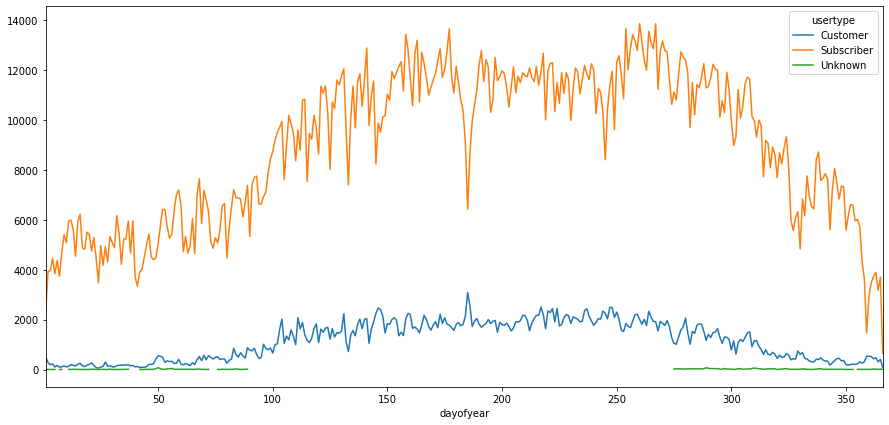

In [125]:
#cb.groupby(['dayofyear', 'usertype'])['bikeid'].count()

fig, ax = plt.subplots(figsize=(15,7))
temp.groupby(['dayofyear', 'usertype']).count()['bikeid'].unstack().plot(ax=ax)

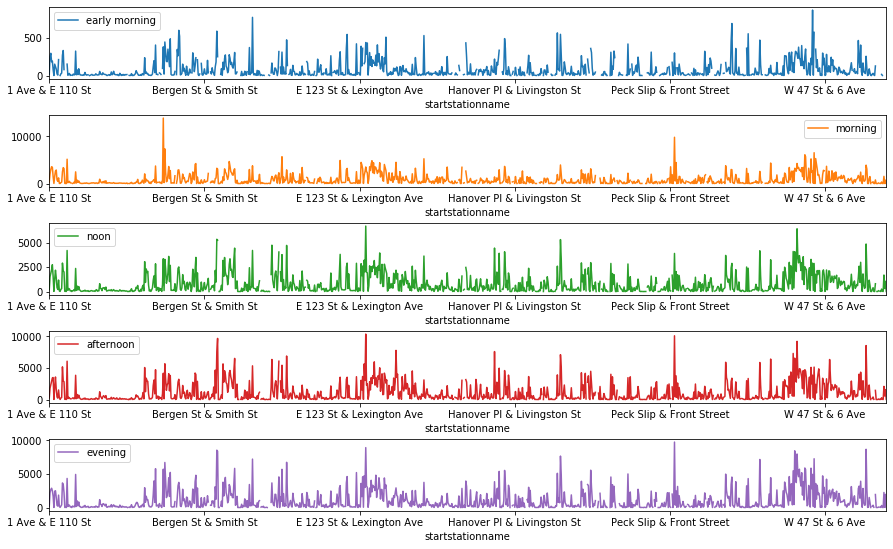

In [424]:
#tweak plot
#number of rides by part of day and starting station name
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5, figsize=(15,7))

grouped = cb.groupby(['part_of_day', 'startstationname'])['bikeid'].count().unstack().reindex(['early morning', 'morning', 'noon', 'afternoon', 'evening']).stack().swaplevel(i='part_of_day', j='startstationname').groupby('part_of_day')

for name, group in grouped:
    line1 = group.sort_values(ascending=False)[group>50].plot(ax=ax1)
    line2 = group.sort_values(ascending=False)[group<-50].plot(ax=ax2)

#cb.groupby(['part_of_day', 'startstationname'])['bikeid'].count().unstack().reindex(['early morning', 'morning', 'noon', 'afternoon', 'evening']).stack().swaplevel(i='part_of_day', j='startstationname').unstack().plot(ax=(ax1,ax2,ax3,ax4,ax5), subplots=True)
plt.subplots_adjust(bottom=0, right=0.9, top=1, hspace = 0.5)

#plt.subplots_adjust(bottom=0, right=0.9, top=1, hspace = 0.5)
# fig, ax = plt.subplots(figsize=(15,7))
# cb.groupby(['startstationname','part_of_day']).count()['bikeid'].unstack().plot(ax=ax, subplots=True)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.title('Number of Rides by Unique Station')

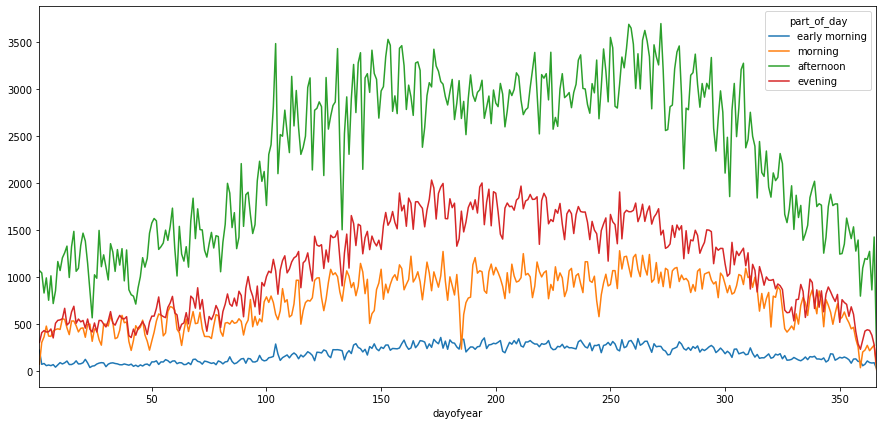

In [126]:
#cb.groupby(['part_of_day','dayofyear']).count()['bikeid'].unstack().reindex(['early morning', 'morning', 'noon', 'afternoon', 'evening']).stack().swaplevel(i='part_of_day', j='dayofyear').unstack()

fig, ax = plt.subplots(figsize=(15,7))
temp.groupby(['part_of_day','dayofyear']).count()['bikeid'].unstack().reindex(['early morning', 'morning', 'noon', 'afternoon', 'evening']).stack().swaplevel(i='part_of_day', j='dayofyear').unstack().plot(ax=ax)

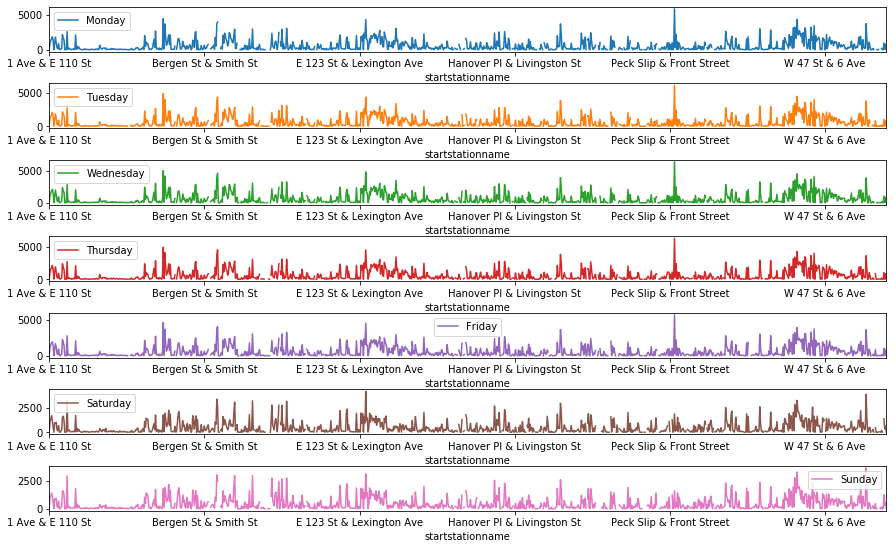

In [330]:
#cb.groupby(['day','part_of_day','startstationname'])['bikeid'].count().sort_values(ascending=False)

#cb.groupby(['day', 'startstationname'])['bikeid'].count().rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}).unstack().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).stack().swaplevel(i='day', j='startstationname').unstack()
fig, ax = plt.subplots(figsize=(15,7))
cb.groupby(['day', 'startstationname'])['bikeid'].count().rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}).unstack().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).stack().swaplevel(i='day', j='startstationname').unstack().plot(ax=ax, subplots=True)
plt.subplots_adjust(bottom=0, right=0.9, top=1, hspace = 0.7)

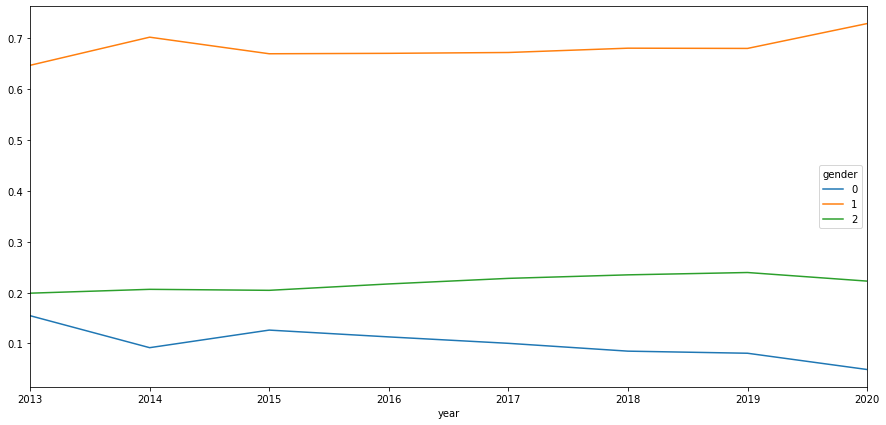

In [135]:
#percentage user by year and gender

fig, ax = plt.subplots(figsize=(15,7))
(cb.groupby(['year', 'gender'])['bikeid'].count()/cb.groupby(['year'])['bikeid'].count()).unstack().plot(ax=ax)


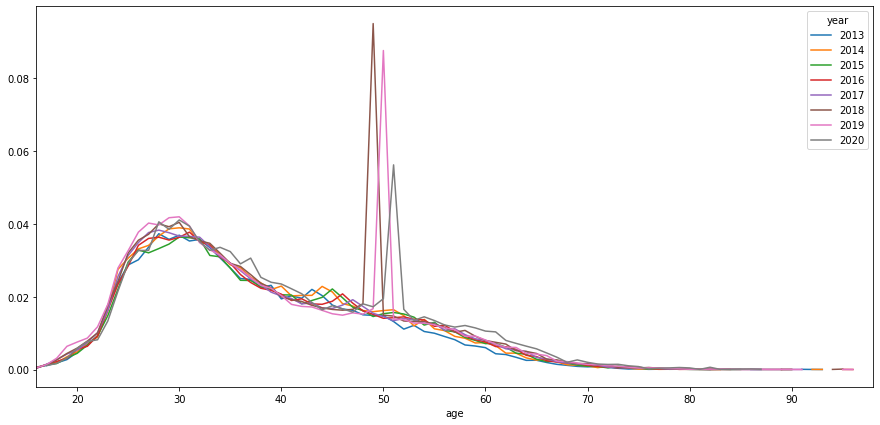

In [133]:
#percent of ridership by age and year

fig, ax = plt.subplots(figsize=(15,7))
(cb.groupby(['age', 'year'])['bikeid'].count()/cb.groupby(['year'])['bikeid'].count()).unstack()[:83].plot(ax=ax)

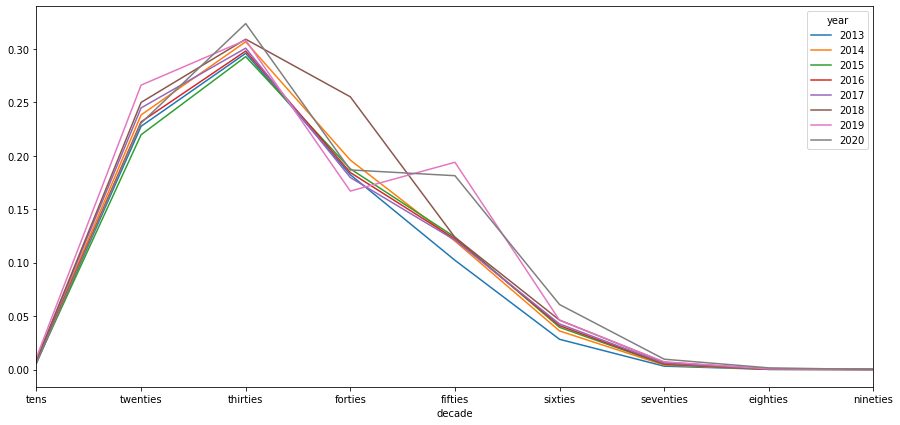

In [132]:
#percent ridership by decadal age of rider and year
#(cb.groupby(['decade', 'year'])['bikeid'].count()/cb.groupby(['year'])['bikeid'].count()).unstack()[1:].reindex(['tens', 'twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties'])

fig, ax = plt.subplots(figsize=(15,7))
(cb.groupby(['decade', 'year'])['bikeid'].count()/cb.groupby(['year'])['bikeid'].count()).unstack()[1:].reindex(['tens', 'twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties']).plot(ax=ax)

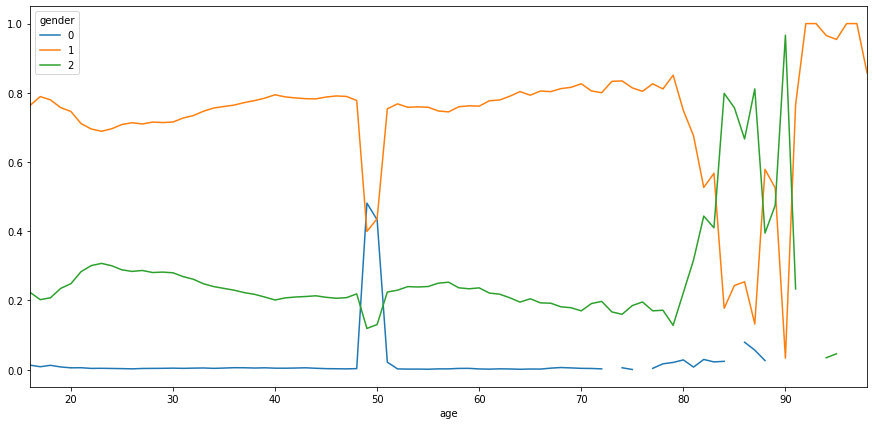

In [140]:
#percent ridership by gender and age
#cb.groupby(['gender', 'age'])['bikeid'].count()/cb.groupby(['age'])['bikeid'].count()

fig, ax = plt.subplots(figsize=(15,7))
(cb.groupby(['age', 'gender'])['bikeid'].count()/cb.groupby(['age'])['bikeid'].count()).unstack()[:83].plot(ax=ax)

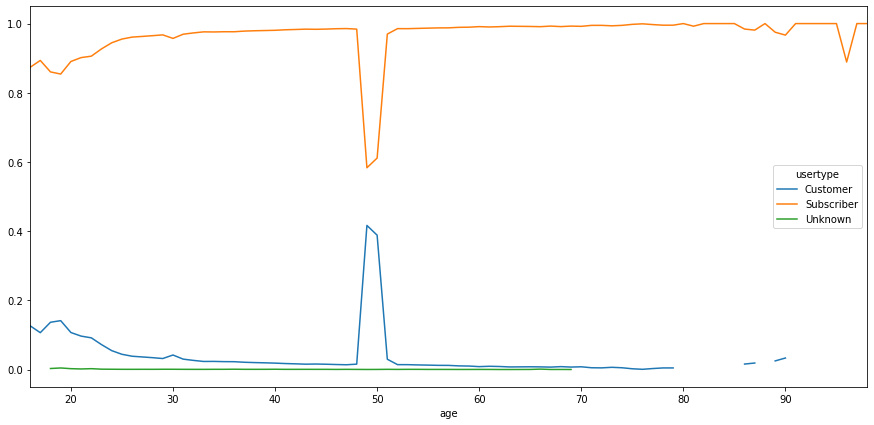

In [243]:
fig, ax = plt.subplots(figsize=(15,7))
(cb.groupby(['age', 'usertype'])['bikeid'].count()/cb.groupby(['age'])['bikeid'].count()).unstack()[:83].plot(ax=ax)

## Inspect data

In [136]:
#need to fix ride discrepencies here before proceeding with using day of week EDA seriously
len(cb.startday)-(cb.startday==cb.stopday).sum()

AttributeError: 'DataFrame' object has no attribute 'startday'

In [20]:
cb.gender.value_counts()

1    2714020
2     892104
0     411447
Name: gender, dtype: int64

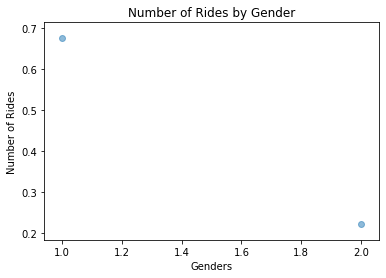

In [37]:
x=cb.gender.value_counts().index[0:2]
y=cb.gender.value_counts()/cb.gender.value_counts().sum()
y = y[0:2]
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Genders')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Gender')
plt.show()

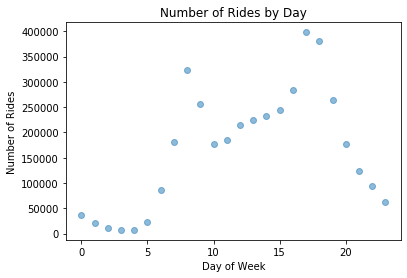

In [23]:
dat = cb.starttime.apply(lambda l: l.hour).value_counts().sort_index()
x = dat.index
y = dat.values
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day')
plt.show()

In [ ]:
cb.startday.value_counts()

In [ ]:
x=cb.startday.value_counts().index
y=cb.startday.value_counts()/(343) #divide by number of weeks to get mean rides per day
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day')
plt.show()

In [ ]:
x=cb.starthour.value_counts().index
y=cb.starthour.value_counts()
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Hour')
plt.show()

In [ ]:
x=cb.endhour.value_counts().index
y=cb.endhour.value_counts()
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Hour')
plt.show()

In [ ]:
x=cb.startmonth.value_counts().index
y=cb.startmonth.value_counts()
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Month of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Month')
plt.show()

In [ ]:
index=[1,7,8,9,10,11,12]
#y[index] = y[index]*(6/7) #to fix over sampling from Jan 2020 and July-December 2013
y = y.round().astype('int32')

In [ ]:
#ad-hocly adjusted for the oversampling of Jan, July-December months 
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Month of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Month')
plt.show()

In [ ]:
#adjusted for ease of interpretation
x=cb['tripdistance'].sort_values(ascending=False).index
y=cb['tripdistance'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
cb.groupby('startmonth').boxplot(column=['tripdistance'], by='startmonth', ax=ax)
plt.show()

In [ ]:
l_init = []
for i in range(len(fin_dat.columns)):
    #print('-'*55)
    #print(train.columns[i], 100*max(train.loc[:,train.columns[i]].dropna().value_counts())/len(train))
    l_init.append(100*max(fin_dat.loc[:,fin_dat.columns[i]].dropna().value_counts())/len(fin_dat))

percent_class = pd.DataFrame()
percent_class['Percent_of_Class'] = l_init
percent_class['Feature_Name'] = fin_dat.columns
percent_class.sort_values(by='Percent_of_Class', ascending=False)['Percent_of_Class'][:50]

percent_class.sort_values(by='Percent_of_Class', ascending=False)
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,10))

ft = percent_class.sort_values(by='Percent_of_Class', ascending=False)['Feature_Name'][:50]
per = percent_class.sort_values(by='Percent_of_Class', ascending=False)['Percent_of_Class'][:50]
y_pos = np.arange(15)
ax.barh(y_pos, per, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ft)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent Appearance of Most Frequent Class')
ax.set_title('Percent Appearance of Most Frequent Class by Feature')